In [3]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy

import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
import umap.umap_ as umap
import skdim
from scipy.spatial import cKDTree
import pickle

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

sns.set(style='white', context='notebook')

In [1]:
path_to_hpc = '/Users/amir/Desktop/for Abdel/OS Basic/1/HC/post_trial5_2017-09-27_14-18-24/HPC_100_CH46.continuous.mat'
path_to_states = '/Users/amir/Desktop/for Abdel/OS Basic/1/HC/post_trial5_2017-09-27_14-18-24/post_trial5_2017-09-27_14-18-24-states.mat'

In [12]:
config = emd.sift.SiftConfig.from_yaml_file('/Users/amir/Desktop/for Abdel/OS Basic/emd_masksift_CA1_config_2500.yml')

In [4]:
lfpHPC, hypno, fs = get_data(path_to_hpc, path_to_states)

frequency sampling of the data is: 2500
There was 0 in the dataset


In [5]:
def extract_pt_intervals(lfp, hypno, fs=2500):
  targetFs = 500
  n_down = fs/targetFs
  start, end = get_start_end(hypno=hypno, sleep_state_id=5)
  rem_interval = nap.IntervalSet(start=start, end=end)
  fs = int(n_down*targetFs)
  t = np.arange(0, len(lfpHPC)/fs, 1/fs)
  lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

  # Detect phasic intervals
  lfpHPC_down = preprocess(lfpHPC, n_down)
  phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

  # Create phasic REM IntervalSet
  start, end = [], []
  for rem_idx in phREM:
    for s, e in phREM[rem_idx]:
      start.append(s/targetFs)
      end.append(e/targetFs)
  phasic_interval = nap.IntervalSet(start, end)

  tonic_interval = rem_interval.set_diff(phasic_interval)

  return phasic_interval, tonic_interval, lfp

In [6]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

In [7]:
## UTILS
# Function to load LFP data from .mat files
# The input includes both the LFP datafile and the sleep-scoring states file
# The LFP data should be cleaned using the matlab artifact cleaning

def load_mat_data(path_to_data, file_name, states_file):
    data = loadmat(path_to_data + file_name)
    data = data['PFClfpCleaned'].flatten()

    states = loadmat(path_to_data + states_file)
    states = states['states'].flatten()
    return data, states


# extract first nrem epochs from the sleep-scoring states file
def get_first_NREM_epoch(arr, start):
  start_index = None
  for i in range(start, len(arr)):
    if arr[i] == 3:
      if start_index is None:
        start_index = i
    elif arr[i] != 3 and start_index is not None:
      return (start_index, i - 1, i)

  return (start_index, len(arr) - 1, len(arr)) if start_index is not None else None


# extract all nrem epochs from the sleep-scoring states file

def get_all_NREM_epochs(arr):
  nrem_epochs = []
  next_start = 0
  while next_start < len(arr)-1:
    indices = get_first_NREM_epoch(arr, next_start)
    if indices == None:
      break
    start, end, next_start = indices
    if end-start <= 30:
      continue
    nrem_epochs.append([start, end])
  return nrem_epochs


# Concatenating all the epochs and filtering on the specified band
def get_filtered_epoch_data(data, epochs, band=(0.1, 4), fs=2500):
  epoch_data = []
  for start, end in epochs:
    data_part = data[start*fs:end*fs]
    epoch_data.extend(data_part)
  epoch_data = np.array(epoch_data)
  filtered_epoch_data = filter_signal(epoch_data, fs, 'bandpass', band, n_cycles=3, filter_type='iir', butterworth_order=6, remove_edges=False)
  return filtered_epoch_data, epoch_data


# Get cycle filtered on conditions. Make a copy so the original is not affected.
def get_cycles_with_conditions(cycles, conditions):
    C = copy.deepcopy(cycles)
    C.pick_cycle_subset(conditions)
    return C


# Functions to calculate metrics
def peak_before_trough(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return arr[i]
  return -1

def peak_before_trough_pos(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 1, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return i
  return -1

def peak_to_trough_duration(arr):
  trough_val = np.min(arr)
  trough_pos = np.argmin(arr)
  for i in range(trough_pos - 20, 0, -1):
    if arr[i] > arr[i - 1] and arr[i] > arr[i + 1] and arr[i]>=0:
      return trough_pos-i
  return -1

def num_inflection_points(arr):
  sign_changes = np.diff(np.sign(np.diff(arr, 2)))
  num_inflection_points = np.sum(sign_changes != 0)
  return num_inflection_points

def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)

# Compute metrics for each cycle -
#     Maximum Amplitude
#     Cycle Duration
#     Trough Position and values
#     Peak (just before the trough) Position and Values
#     Peak Position and Values
#     Peak-to-Trough Duration
#     Peak to trough ratio ( P / P+T )
#     Ascending to Descending ratio ( A / A+D )
def get_cycles_with_metrics(cycles, data, IA, IF, conditions=None):
  C = copy.deepcopy(cycles)

  C.compute_cycle_metric('duration_samples', data, func=len, mode='augmented')
  C.compute_cycle_metric('peak2trough', data, func=peak2trough, mode='augmented')
  C.compute_cycle_metric('asc2desc', data, func=asc2desc, mode='augmented')
  C.compute_cycle_metric('max_amp', IA, func=np.max, mode='augmented')
  C.compute_cycle_metric('trough_values', data, func=np.min, mode='augmented')
  C.compute_cycle_metric('peak_values', data, func=np.max, mode='augmented')
  C.compute_cycle_metric('mean_if', IF, func=np.mean, mode='augmented')
  C.compute_cycle_metric('max_if', IF, func=np.max, mode='augmented')
  C.compute_cycle_metric('range_if', IF, func=compute_range, mode='augmented')
  C.compute_cycle_metric('trough_position', data, func=np.argmin, mode='augmented')
  C.compute_cycle_metric('peak_position', data, func=np.argmax, mode='augmented')

  return C


def get_cycle_inds(cycles, subset_indices):
  all_cycles_inds = []
  for idx in subset_indices:
    if idx != -1:
      inds = cycles.get_inds_of_cycle(idx, mode='augmented')
      all_cycles_inds.append(inds)

  return all_cycles_inds

def arrange_cycle_inds(all_cycles_inds):
  cycles_inds = []
  for ii in range(len(all_cycles_inds)):
    cycle = all_cycles_inds[ii]
    start = cycle[0]
    end = cycle[-1]
    cycles_inds.append([start, end])

  cycles_inds = np.array(cycles_inds)

  return cycles_inds

def compute_mode_frequency_and_entropy(FPP, frequencies, angles):
    mode_frequencies = []
    enropy_values = []
    # Loop through each FPP (assuming FPP is a list or 3D array where each element is a 2D array of power values)
    for fpp in FPP:
        # Ensure that fpp2 has positive values, as power spectra should be non-negative
        fpp = np.abs(fpp)

        # Normalize fpp2 across all values (sum all elements)
        fpp2_sum = np.sum(fpp)
        normalized_fpp2 = fpp / fpp2_sum  # Normalize so that the sum of fpp is 1

        # Find the index of the maximum value in normalized_fpp2 (Mode Frequency)
        max_index = np.unravel_index(np.argmax(normalized_fpp2, axis=None), fpp.shape)
        mode_frequency = frequencies[max_index[0]]  # Extract mode frequency

        avg_fpp2 = np.sum(normalized_fpp2, axis=1)
        window_size = 5  # 5 Hz window
        smoothed_avg_fpp = np.convolve(avg_fpp2, np.ones(window_size)/window_size, mode='same')

        # Normalize smoothed_avg_fpp to [0, 1] for plotting
        smoothed_avg_fpp_norm = (smoothed_avg_fpp - np.min(smoothed_avg_fpp)) / (np.max(smoothed_avg_fpp) - np.min(smoothed_avg_fpp))
        dist_smoothed_avg_fpp_norm = smoothed_avg_fpp_norm/np.sum(smoothed_avg_fpp_norm)
        # Shannon entropy calculation
        shannon_entropy = entropy(dist_smoothed_avg_fpp_norm, base=2)
        enropy_values.append(shannon_entropy)
        # Append results to the lists
        mode_frequencies.append(mode_frequency)

    return np.array(mode_frequencies), np.array(enropy_values)

def abids(X,k):
    search_struct = cKDTree(X)
    return np.array([abid(X,k,x,search_struct) for x in X])


def abid(X,k,x,search_struct,offset=1):
    neighbor_norms, neighbors = search_struct.query(x,k+offset)
    neighbors = X[neighbors[offset:]] - x
    normed_neighbors = neighbors / neighbor_norms[offset:,None]
    # Original publication version that computes all cosines
    # coss = normed_neighbors.dot(normed_neighbors.T)
    # return np.mean(np.square(coss))**-1
    # Using another product to get the same values with less effort
    para_coss = normed_neighbors.T.dot(normed_neighbors)

    return k**2 / np.sum(np.square(para_coss))

In [8]:
def get_cycle_data(imf5, fs=2500):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [9]:
def prepare_data_for_umap(imfs, imf_frequencies):

  waveforms = pd.DataFrame()
  all_trials = pd.DataFrame()
  all_FPPs = []

  theta_range = [5, 12]
  frequencies = np.arange(15, 141, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs=2500)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/17

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

    # Compute mode frequency for each cycle
    mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

    all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
    all_waveforms = pd.DataFrame(all_waveforms.T)

    waveforms = pd.concat([waveforms, all_waveforms])

    trial = all_cycles.get_metric_dataframe(subset=True)
    trial['mode_freqs'] = mode_freqs
    trial['entropy'] = entropies
    all_trials = pd.concat([all_trials, trial])

  return waveforms, all_trials, all_FPPs

In [13]:
tonic_imfs, tonic_imfs_freqs, tonic_rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, tonic_interval, config, return_imfs_freqs=True)

In [14]:
phasic_imfs, phasic_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(lfp, fs, phasic_interval, config, return_imfs_freqs=True)

In [15]:
all_phasic_waveforms, all_phasic_trials, all_phasic_FPPs = prepare_data_for_umap(phasic_imfs, phasic_imfs_freqs)
all_tonic_waveforms, all_tonic_trials, all_tonic_FPPs = prepare_data_for_umap(tonic_imfs, tonic_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

In [16]:
all_tonic_trials['episode_type'] = 'tonic'
all_phasic_trials['episode_type'] = 'phasic'
# Concatenate tonic and phasic trials
combined_trials = pd.concat([all_tonic_trials, all_phasic_trials], axis=0)

combined_waveforms = np.concatenate([all_tonic_waveforms, all_phasic_waveforms], axis=0)

In [17]:
combined_waveforms = np.array(combined_waveforms)

In [18]:
ID = np.round(np.nanmean(abids(combined_waveforms, 50)))
ID

3.0

In [19]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding_combined = umap_embedder.fit_transform(combined_waveforms)

# Extract UMAP embeddings
emb_combined = embedding_combined

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


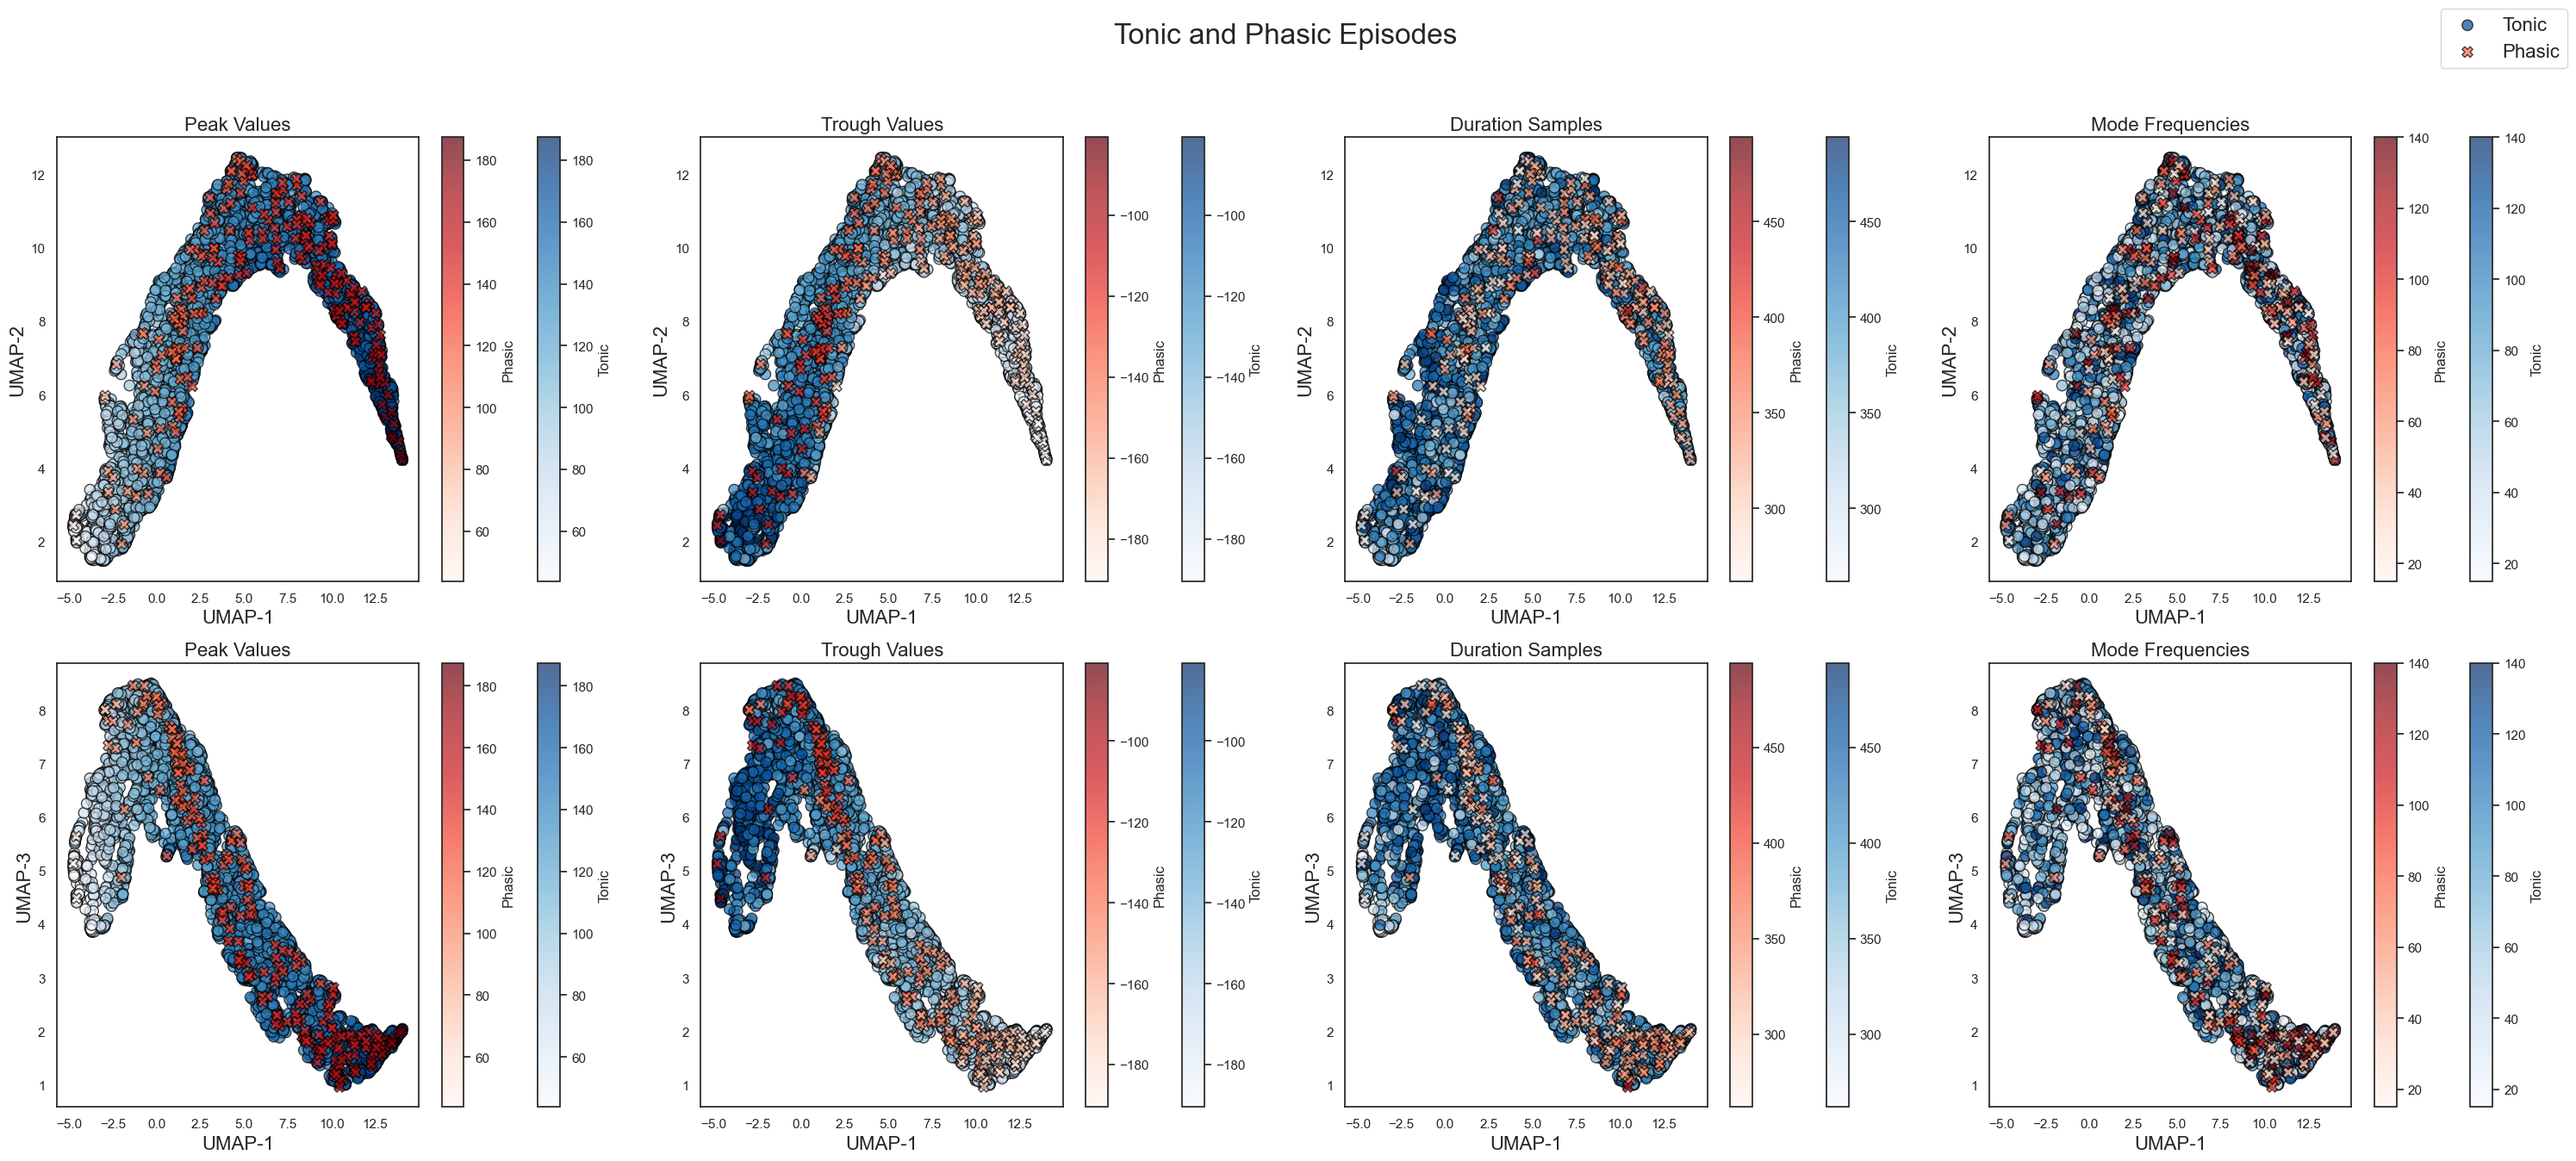

In [20]:
# Define the metrics
metrics = ['peak_values', 'trough_values', 'duration_samples', 'mode_freqs']
titles = ['Peak Values', 'Trough Values', 'Duration Samples', 'Mode Frequencies']

tonic_cmap = 'Blues'   
phasic_cmap = 'Reds' 

f, ax = plt.subplots(2, 4, figsize=(30, 14))

# Plot first set (UMAP-1, UMAP-2)
for i, metric in enumerate(metrics):
    # Tonic episodes
    tonic_mask = combined_trials['episode_type'] == 'tonic'
    scatter_tonic = ax[0, i].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 1],
                                     c=combined_trials[tonic_mask][metric],
                                     vmin=np.percentile(combined_trials[metric], 1),
                                     vmax=np.percentile(combined_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    phasic_mask = combined_trials['episode_type'] == 'phasic'
    scatter_phasic = ax[0, i].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 1],
                                      c=combined_trials[phasic_mask][metric],
                                      vmin=np.percentile(combined_trials[metric], 1),
                                      vmax=np.percentile(combined_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

# Plot second set (UMAP-1, UMAP-3)
for i, metric in enumerate(metrics):
    # Tonic episodes
    scatter_tonic = ax[1, i].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 2],
                                     c=combined_trials[tonic_mask][metric],
                                     vmin=np.percentile(combined_trials[metric], 1),
                                     vmax=np.percentile(combined_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    scatter_phasic = ax[1, i].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 2],
                                      c=combined_trials[phasic_mask][metric],
                                      vmin=np.percentile(combined_trials[metric], 1),
                                      vmax=np.percentile(combined_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("Tonic and Phasic Episodes", fontsize=24)
plt.savefig('phasic_and_tonic_metrics.svg')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

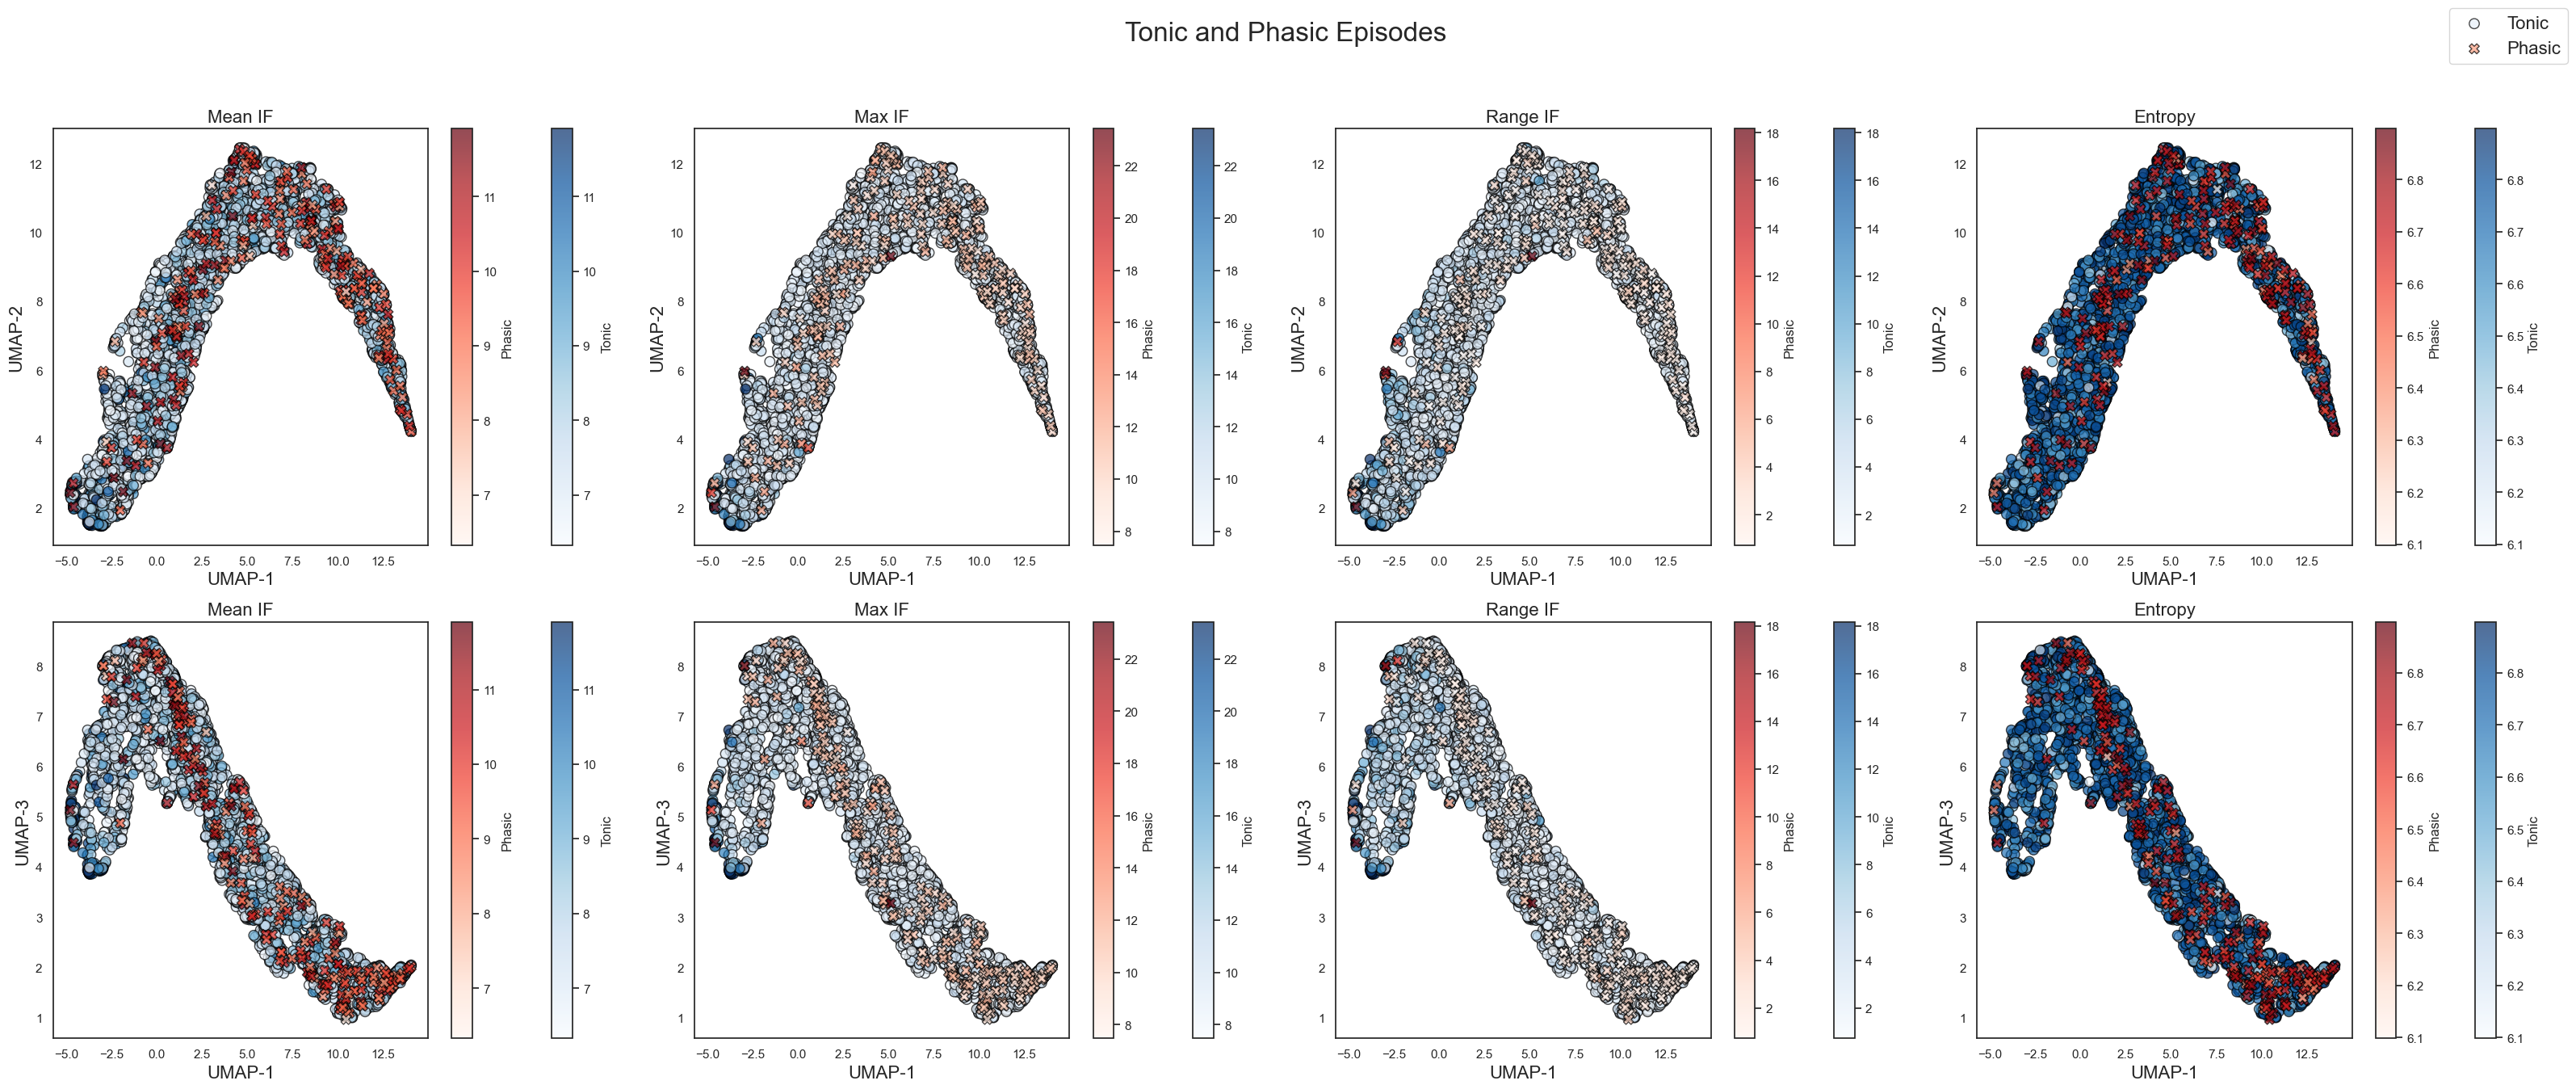

In [21]:
# Define the metrics
metrics = ['mean_if', 'max_if', 'range_if', 'entropy']
titles = ['Mean IF', 'Max IF', 'Range IF', 'Entropy']

tonic_cmap = 'Blues'   
phasic_cmap = 'Reds' 

f, ax = plt.subplots(2, 4, figsize=(32, 14))

# Plot first set (UMAP-1, UMAP-2)
for i, metric in enumerate(metrics):
    # Tonic episodes
    tonic_mask = combined_trials['episode_type'] == 'tonic'
    scatter_tonic = ax[0, i].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 1],
                                     c=combined_trials[tonic_mask][metric],
                                     vmin=np.percentile(combined_trials[metric], 1),
                                     vmax=np.percentile(combined_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    phasic_mask = combined_trials['episode_type'] == 'phasic'
    scatter_phasic = ax[0, i].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 1],
                                      c=combined_trials[phasic_mask][metric],
                                      vmin=np.percentile(combined_trials[metric], 1),
                                      vmax=np.percentile(combined_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

# Plot second set (UMAP-1, UMAP-3)
for i, metric in enumerate(metrics):
    # Tonic episodes
    scatter_tonic = ax[1, i].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 2],
                                     c=combined_trials[tonic_mask][metric],
                                     vmin=np.percentile(combined_trials[metric], 1),
                                     vmax=np.percentile(combined_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    scatter_phasic = ax[1, i].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 2],
                                      c=combined_trials[phasic_mask][metric],
                                      vmin=np.percentile(combined_trials[metric], 1),
                                      vmax=np.percentile(combined_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("Tonic and Phasic Episodes", fontsize=24)
plt.savefig('phasic_and_tonic_metrics_2.svg')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

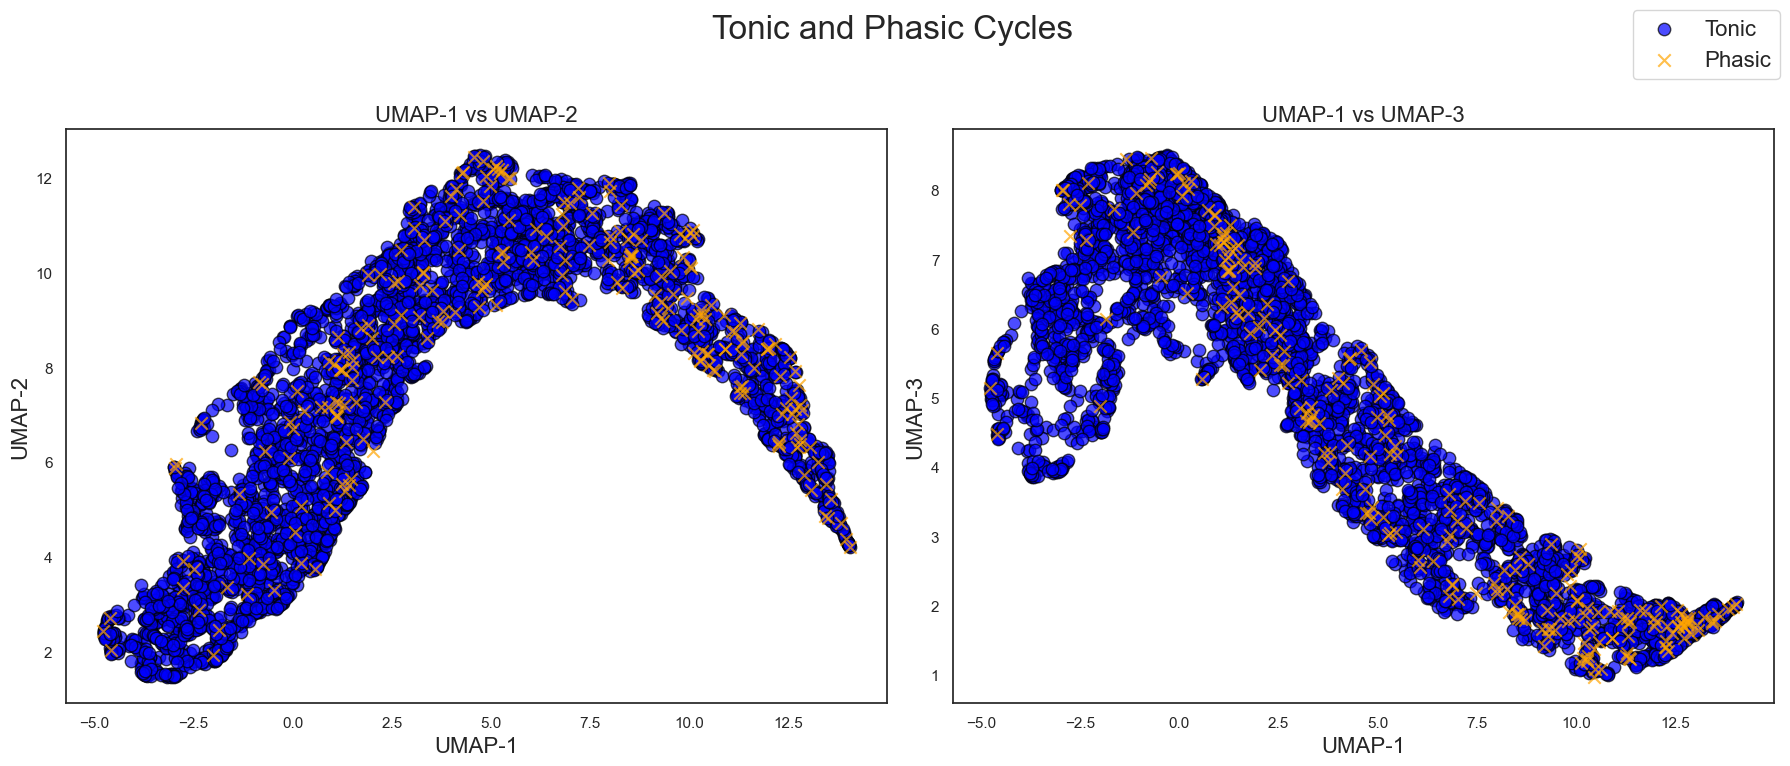

In [22]:
tonic_cmap = 'Blues'   
phasic_cmap = 'Oranges' 

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot UMAP-1 vs UMAP-2
# Tonic episodes
tonic_mask = combined_trials['episode_type'] == 'tonic'
scatter_tonic = ax[0].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 1],
                             c='blue',
                             label='Tonic', s=80, alpha=0.7, edgecolor='black')

# Phasic episodes
phasic_mask = combined_trials['episode_type'] == 'phasic'
scatter_phasic = ax[0].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 1],
                               c='orange',
                               label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[0].set_xlabel('UMAP-1', fontsize=16)
ax[0].set_ylabel('UMAP-2', fontsize=16)
ax[0].set_title('UMAP-1 vs UMAP-2', fontsize=16)

# Plot UMAP-1 vs UMAP-3
scatter_tonic = ax[1].scatter(emb_combined[tonic_mask, 0], emb_combined[tonic_mask, 2],
                             c='blue',
                             label='Tonic', s=80, alpha=0.7, edgecolor='black')

scatter_phasic = ax[1].scatter(emb_combined[phasic_mask, 0], emb_combined[phasic_mask, 2],
                               c='orange',
                               label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[1].set_xlabel('UMAP-1', fontsize=16)
ax[1].set_ylabel('UMAP-3', fontsize=16)
ax[1].set_title('UMAP-1 vs UMAP-3', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, ['Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("Tonic and Phasic Cycles", fontsize=24)
plt.savefig('phasic_and_tonic_cycles.svg')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [23]:
phasic_interval, tonic_interval, lfp = extract_pt_intervals(lfpHPC, hypno)

start, end = get_start_end(hypno=hypno, sleep_state_id=5)
rem_interval = nap.IntervalSet(start=start, end=end)

# Extract IMFs during REM sleep
rem_imfs, rem_imfs_freqs, rem_lpf = extract_imfs_by_pt_intervals(
    lfp, fs, rem_interval, config, return_imfs_freqs=True
)

In [24]:
def prepare_rem_data_for_umap(imfs, imf_frequencies):
    waveforms = pd.DataFrame()
    all_trials = pd.DataFrame()
    all_FPPs = []

    theta_range = [5, 12]
    frequencies = np.arange(15, 141, 1)
    angles = np.linspace(-180, 180, 19)
    fs = 2500

    for idx, imf in enumerate(imfs):
        cycle_data = get_cycle_data(imf[:, 5], fs=2500)

        amp_thresh = np.percentile(cycle_data['IA'], 25)
        lo_freq_duration = fs/5
        hi_freq_duration = fs/17

        conditions = ['is_good==1',
                      f'duration_samples<{lo_freq_duration}',
                      f'duration_samples>{hi_freq_duration}',
                      f'max_amp>{amp_thresh}']

        all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

        subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
        subset_indices = subset_cycles_df['index'].values

        all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
        cycles_inds = arrange_cycle_inds(all_cycles_inds)

        freqs = imf_frequencies[idx]
        sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
        supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

        raw_data = sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5, ret_mode='power', normalise=None)
        supraPlot = scipy.stats.zscore(raw_data, axis=1)
        FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
        all_FPPs.append(FPP)

        mode_freqs, entropies = compute_mode_frequency_and_entropy(FPP, frequencies, angles)

        all_waveforms, _ = emd.cycles.phase_align(cycle_data['IP'], cycle_data['theta_imf'],
                                                  cycles=all_cycles.iterate(through='subset'), npoints=100)
        all_waveforms = pd.DataFrame(all_waveforms.T)

        waveforms = pd.concat([waveforms, all_waveforms])

        trial = all_cycles.get_metric_dataframe(subset=True)
        trial['mode_freqs'] = mode_freqs
        trial['entropy'] = entropies
        all_trials = pd.concat([all_trials, trial])

    return waveforms, all_trials, all_FPPs

In [25]:
rem_waveforms, rem_trials, rem_FPPs = prepare_rem_data_for_umap(rem_imfs, rem_imfs_freqs)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

In [26]:
ID = np.round(np.nanmean(abids(rem_waveforms, 50)))
ID

ValueError: x must consist of vectors of length 100 but has shape (1,)

In [27]:
umap_embedder = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', random_state=42)
embedding_rem = umap_embedder.fit_transform(rem_waveforms)

def project_cycles(waveforms, embedder):
    return embedder.transform(waveforms)

In [28]:
phasic_waveforms, phasic_trials, _ = prepare_data_for_umap(phasic_imfs, phasic_imfs_freqs)
tonic_waveforms, tonic_trials, _ = prepare_data_for_umap(tonic_imfs, tonic_imfs_freqs)

phasic_embedding = project_cycles(phasic_waveforms, umap_embedder)
tonic_embedding = project_cycles(tonic_waveforms, umap_embedder)

 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking Cycles inputs - trimming singleton from input 'IP'
 Checking phase_align inputs - trimming singleton 

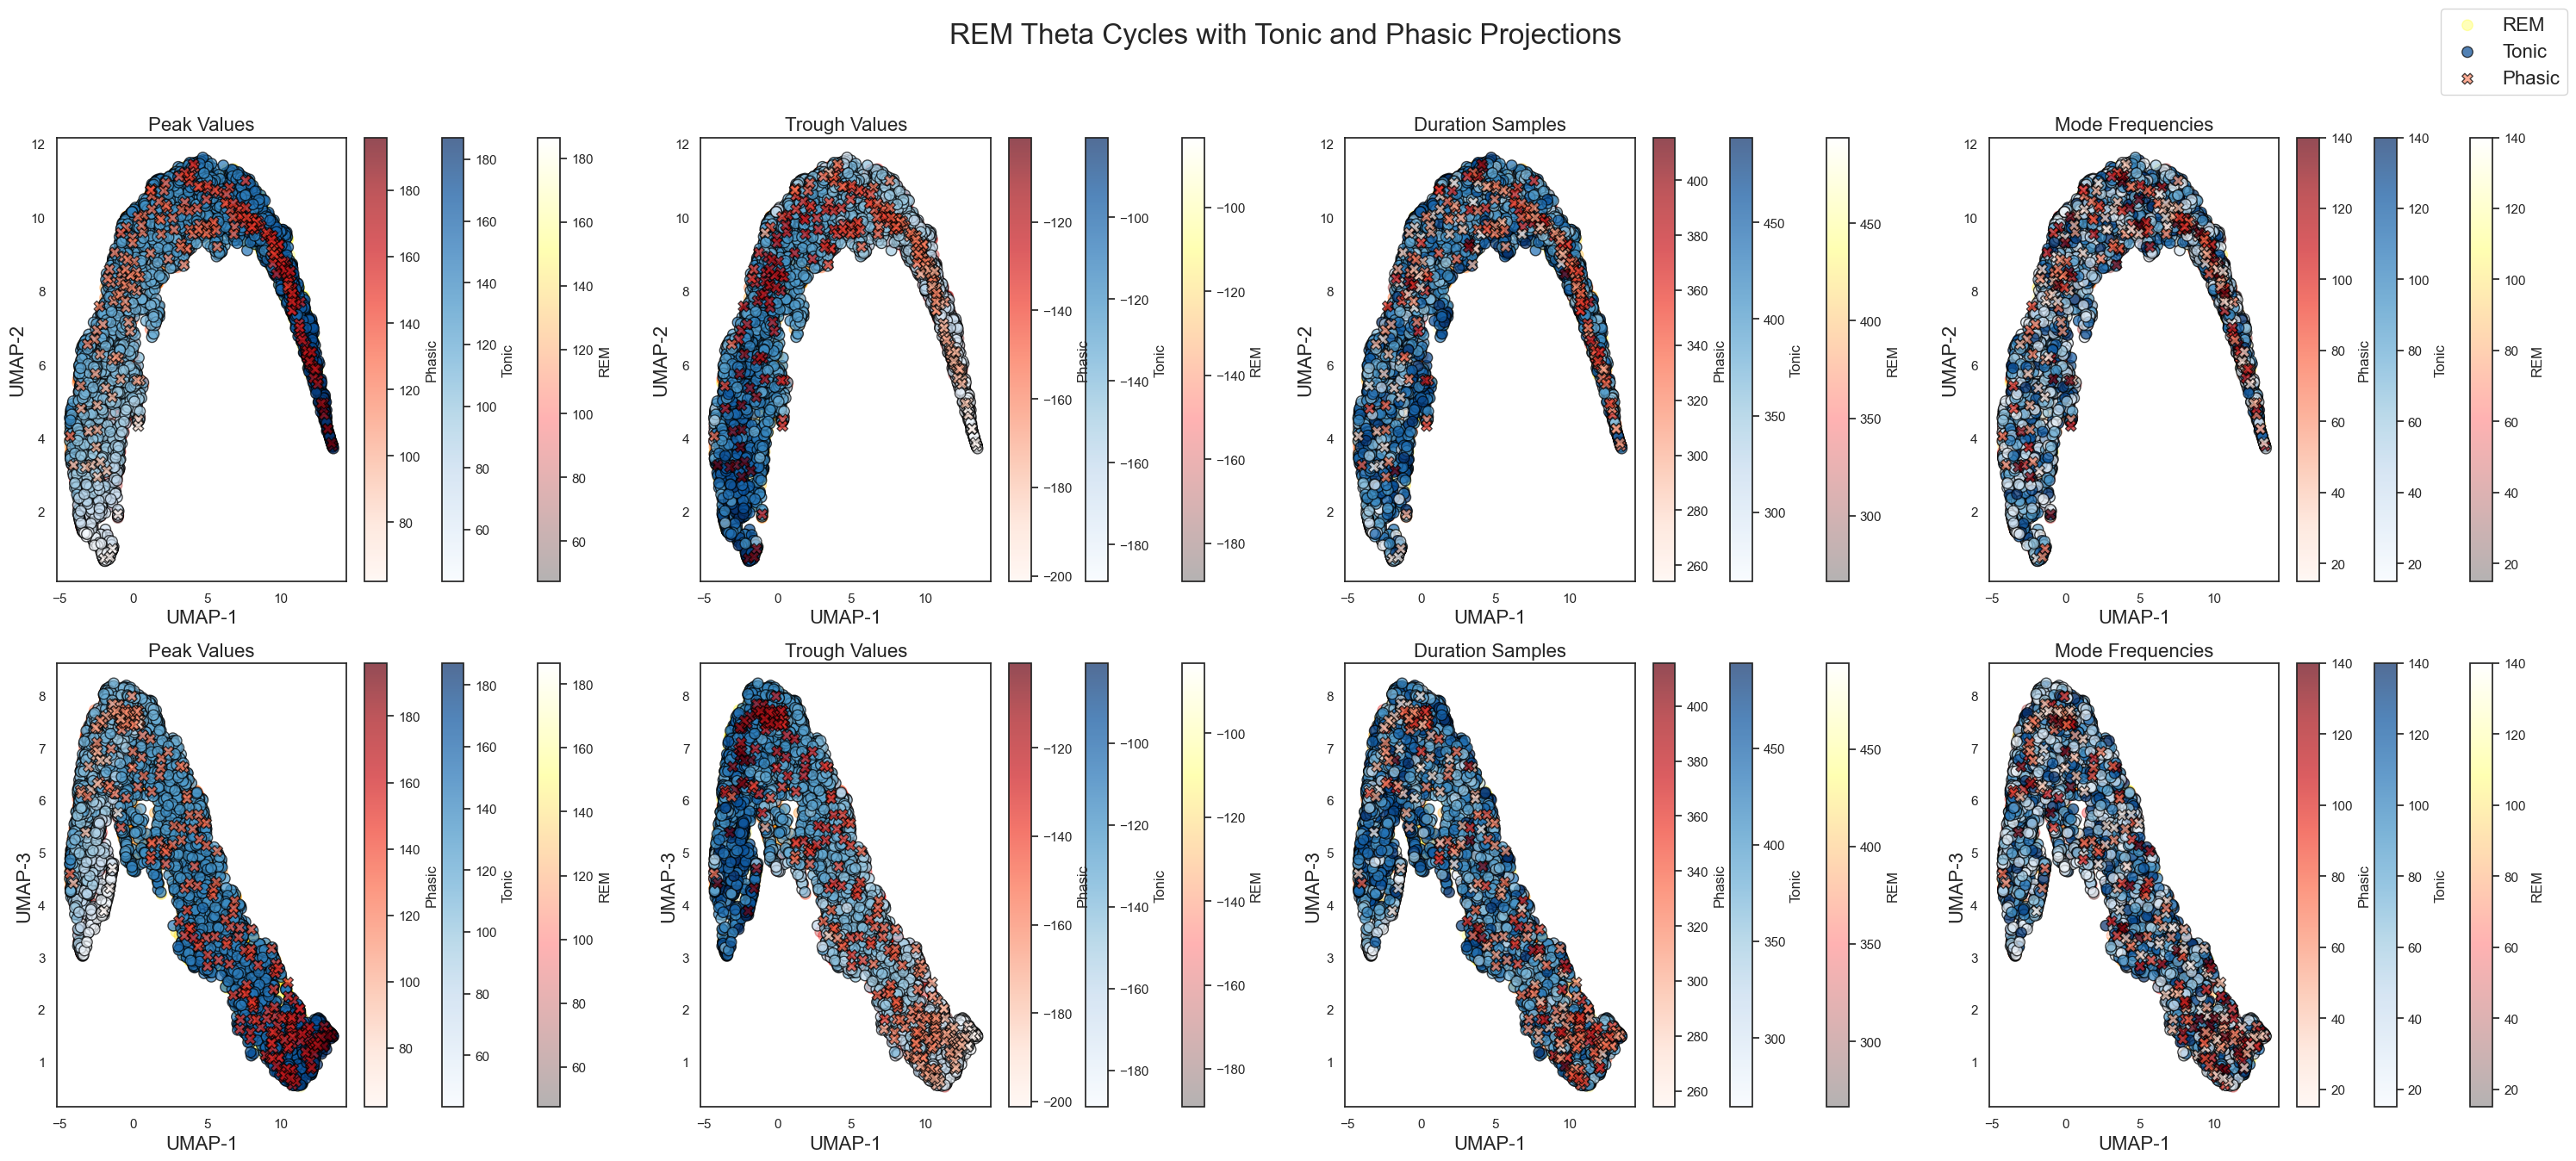

In [29]:
metrics = ['peak_values', 'trough_values', 'duration_samples', 'mode_freqs']
titles = ['Peak Values', 'Trough Values', 'Duration Samples', 'Mode Frequencies']

rem_cmap = 'hot'
tonic_cmap = 'Blues'
phasic_cmap = 'Reds'

f, ax = plt.subplots(2, 4, figsize=(30, 14))

for i, metric in enumerate(metrics):
    # REM episodes
    scatter_rem = ax[0, i].scatter(embedding_rem[:, 0], embedding_rem[:, 1],
                                   c=rem_trials[metric],
                                   vmin=np.percentile(rem_trials[metric], 1),
                                   vmax=np.percentile(rem_trials[metric], 99),
                                   cmap=rem_cmap, s=80, label='REM', alpha=0.3)

    # Tonic episodes
    scatter_tonic = ax[0, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    # Phasic episodes
    scatter_phasic = ax[0, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[0, i].set_xlabel('UMAP-1', fontsize=16)
    ax[0, i].set_ylabel('UMAP-2', fontsize=16)
    ax[0, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_rem, ax=ax[0, i], label='REM', orientation='vertical')
    f.colorbar(scatter_tonic, ax=ax[0, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[0, i], label='Phasic', orientation='vertical')

    # UMAP-1 vs UMAP-3
    scatter_rem = ax[1, i].scatter(embedding_rem[:, 0], embedding_rem[:, 2],
                                   c=rem_trials[metric],
                                   vmin=np.percentile(rem_trials[metric], 1),
                                   vmax=np.percentile(rem_trials[metric], 99),
                                   cmap=rem_cmap, s=80, label='REM', alpha=0.3)

    scatter_tonic = ax[1, i].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                                     c=tonic_trials[metric],
                                     vmin=np.percentile(tonic_trials[metric], 1),
                                     vmax=np.percentile(tonic_trials[metric], 99),
                                     cmap=tonic_cmap, s=80, label='Tonic', alpha=0.7, edgecolor='black')

    scatter_phasic = ax[1, i].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                                      c=phasic_trials[metric],
                                      vmin=np.percentile(phasic_trials[metric], 1),
                                      vmax=np.percentile(phasic_trials[metric], 99),
                                      cmap=phasic_cmap, s=80, label='Phasic', marker='X', alpha=0.7, edgecolor='black')

    ax[1, i].set_xlabel('UMAP-1', fontsize=16)
    ax[1, i].set_ylabel('UMAP-3', fontsize=16)
    ax[1, i].set_title(titles[i], fontsize=16)

    f.colorbar(scatter_rem, ax=ax[1, i], label='REM', orientation='vertical')
    f.colorbar(scatter_tonic, ax=ax[1, i], label='Tonic', orientation='vertical')
    f.colorbar(scatter_phasic, ax=ax[1, i], label='Phasic', orientation='vertical')

handles, labels = ax[0, 0].get_legend_handles_labels()
f.legend(handles, ['REM', 'Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("REM Theta Cycles with Tonic and Phasic Projections", fontsize=24)
plt.savefig('rem_theta_with_phasic_and_tonic_projections.svg')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

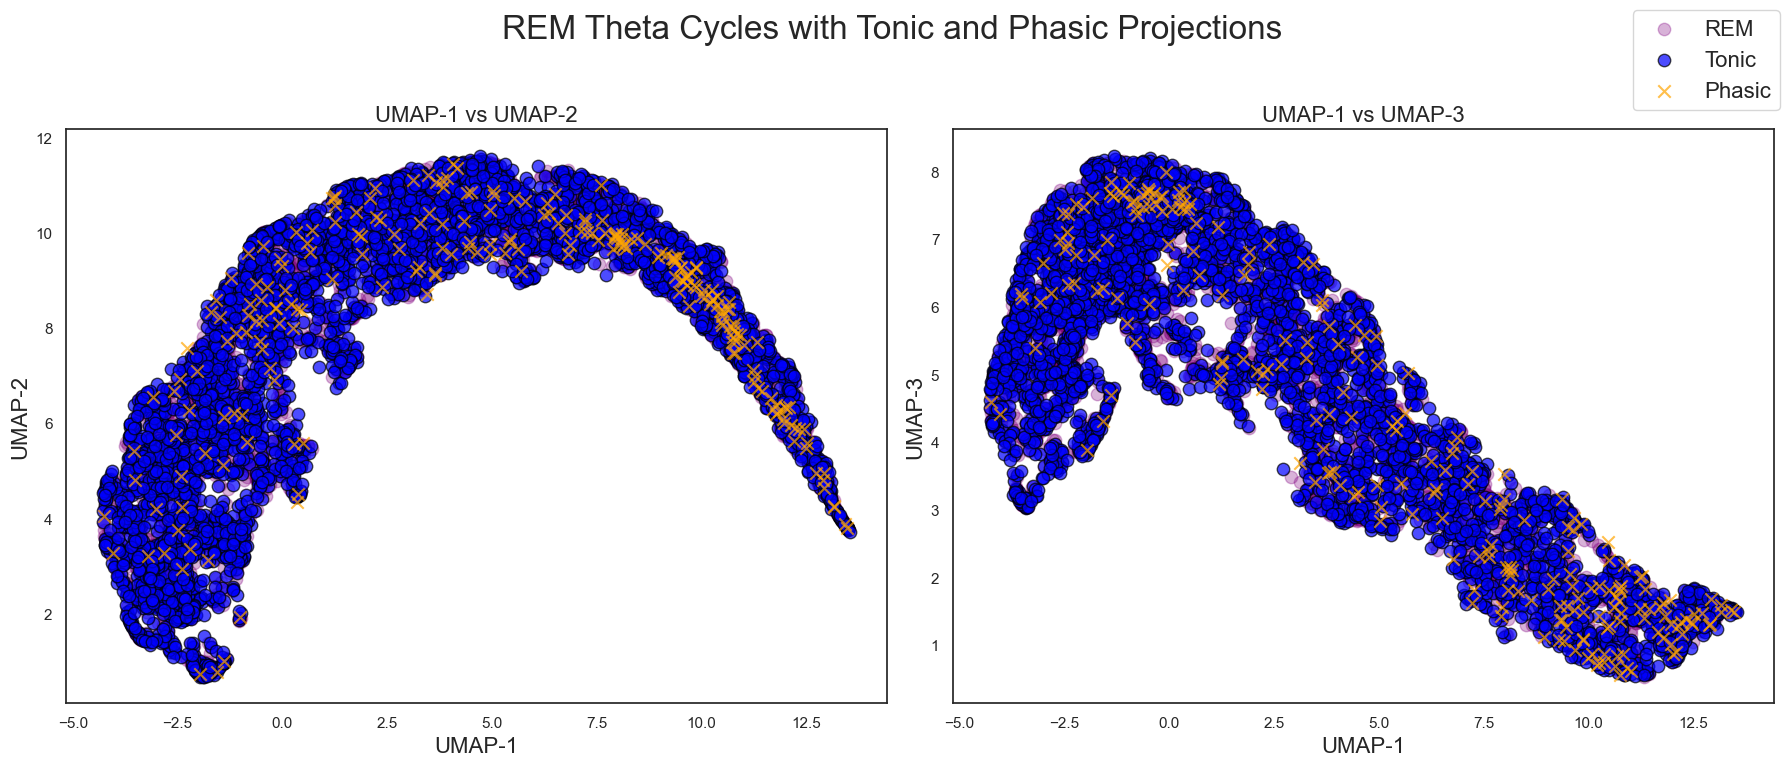

In [30]:
rem_color = 'purple'
tonic_color = 'blue'
phasic_color = 'orange'

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# Plot UMAP-1 vs UMAP-2
# REM episodes
scatter_rem = ax[0].scatter(embedding_rem[:, 0], embedding_rem[:, 1],
                            c=rem_color, label='REM', s=80, alpha=0.3)

# Tonic episodes
scatter_tonic = ax[0].scatter(tonic_embedding[:, 0], tonic_embedding[:, 1],
                              c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

# Phasic episodes
scatter_phasic = ax[0].scatter(phasic_embedding[:, 0], phasic_embedding[:, 1],
                               c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[0].set_xlabel('UMAP-1', fontsize=16)
ax[0].set_ylabel('UMAP-2', fontsize=16)
ax[0].set_title('UMAP-1 vs UMAP-2', fontsize=16)

# Plot UMAP-1 vs UMAP-3
scatter_rem = ax[1].scatter(embedding_rem[:, 0], embedding_rem[:, 2],
                            c=rem_color, label='REM', s=80, alpha=0.3)

scatter_tonic = ax[1].scatter(tonic_embedding[:, 0], tonic_embedding[:, 2],
                              c=tonic_color, label='Tonic', s=80, alpha=0.7, edgecolor='black')

scatter_phasic = ax[1].scatter(phasic_embedding[:, 0], phasic_embedding[:, 2],
                               c=phasic_color, label='Phasic', marker='x', s=80, alpha=0.7, edgecolor='black')

ax[1].set_xlabel('UMAP-1', fontsize=16)
ax[1].set_ylabel('UMAP-3', fontsize=16)
ax[1].set_title('UMAP-1 vs UMAP-3', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, ['REM', 'Tonic', 'Phasic'], loc='upper right', fontsize=16)

plt.suptitle("REM Theta Cycles with Tonic and Phasic Projections", fontsize=24)
plt.savefig('rem_theta_with_phasic_and_tonic_projections_simple.svg')
f.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()